<a href="https://colab.research.google.com/github/SrishtiCodeGit/AI-as-a-Systemic-Factor-in-Portfolio-Risk/blob/main/Measuring_and_Stress_Testing_Technology_Sector_Concentration_Risk_Using_Live_Market_Data_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install yfinance

In [10]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
tickers={
     "AAPL": "Tech",
    "MSFT": "Tech",
    "NVDA": "Tech",
    "AMZN": "Tech",
    "GOOGL": "Tech",
    "META": "Tech",
    "JPM": "Finance",
    "UNH": "Healthcare",
    "XOM": "Energy"
}

In [12]:
data = []

for ticker, sector in tickers.items():
    stock = yf.Ticker(ticker)
    info = stock.info

    data.append({
        "Ticker": ticker,
        "Sector": sector,
        "MarketCap": info.get("marketCap", np.nan)
    })

df = pd.DataFrame(data)
df

,Ticker,Sector,MarketCap
0,AAPL,Tech,4030612373504
1,MSFT,Tech,2977410580480
2,NVDA,Tech,4761299451904
3,AMZN,Tech,2261203812352
4,GOOGL,Tech,3785151479808
5,META,Tech,1653545107456
6,JPM,Finance,818009931776
7,UNH,Healthcare,257439334400
8,XOM,Energy,621097779200


In [13]:
df = df.dropna() #risk model might fail with missing data, drop empty values
df["MarketCap"] = df["MarketCap"] / 1e12  # convert to trillions USD
df # now the market cap is in trillions

,Ticker,Sector,MarketCap
0,AAPL,Tech,4.030612
1,MSFT,Tech,2.977411
2,NVDA,Tech,4.761299
3,AMZN,Tech,2.261204
4,GOOGL,Tech,3.785151
5,META,Tech,1.653545
6,JPM,Finance,0.818010
7,UNH,Healthcare,0.257439
8,XOM,Energy,0.621098


In [14]:

total_market_cap = df["MarketCap"].sum()
df["Weight"] = df["MarketCap"] / total_market_cap
df

,Ticker,Sector,MarketCap,Weight
0,AAPL,Tech,4.030612,0.190431
1,MSFT,Tech,2.977411,0.140671
2,NVDA,Tech,4.761299,0.224953
3,AMZN,Tech,2.261204,0.106833
4,GOOGL,Tech,3.785151,0.178834
5,META,Tech,1.653545,0.078124
6,JPM,Finance,0.818010,0.038648
7,UNH,Healthcare,0.257439,0.012163
8,XOM,Energy,0.621098,0.029344


In [15]:
tech_weight = df[df["Sector"] == "Tech"]["Weight"].sum()

print("Technology sector concentration:", round(tech_weight * 100, 2), "%")

Technology sector concentration: 91.98 %


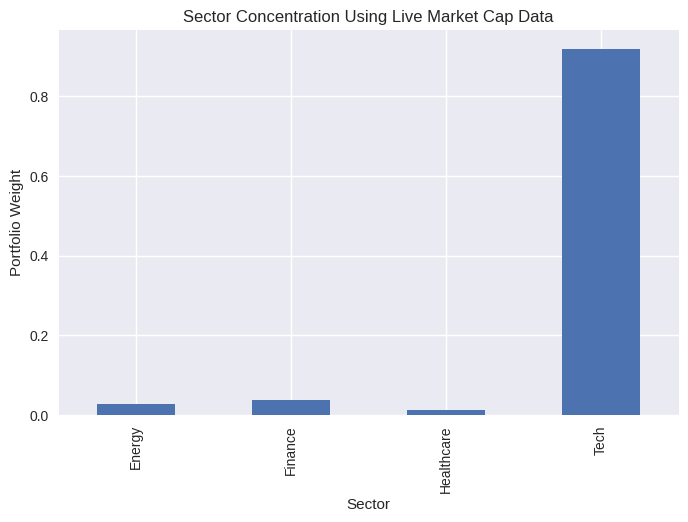

In [16]:
sector_weights = df.groupby("Sector")["Weight"].sum()

plt.figure(figsize=(8,5))
sector_weights.plot(kind="bar")
plt.title("Sector Concentration Using Live Market Cap Data")
plt.ylabel("Portfolio Weight")
plt.show()


In [17]:
shock = -0.25  # 25% tech drawdown (historically reasonable)

df["ShockReturn"] = 0.0
df.loc[df["Sector"] == "Tech", "ShockReturn"] = shock #ONLY for rows where Sector = Tech, replace 0 with -25%.

df["PortfolioImpact"] = df["Weight"] * df["ShockReturn"] #How much damage does each stock do to the portfolio?

portfolio_loss = df["PortfolioImpact"].sum() #This adds up all the damage.

print("Portfolio loss from 25% tech drawdown:",
      round(portfolio_loss * 100, 2), "%") #from decimals to percentages
df #show df

Portfolio loss from 25% tech drawdown: -23.0 %


,Ticker,Sector,MarketCap,Weight,ShockReturn,PortfolioImpact
0,AAPL,Tech,4.030612,0.190431,-0.25,-0.047608
1,MSFT,Tech,2.977411,0.140671,-0.25,-0.035168
2,NVDA,Tech,4.761299,0.224953,-0.25,-0.056238
3,AMZN,Tech,2.261204,0.106833,-0.25,-0.026708
4,GOOGL,Tech,3.785151,0.178834,-0.25,-0.044708
5,META,Tech,1.653545,0.078124,-0.25,-0.019531
6,JPM,Finance,0.818010,0.038648,0.00,0.000000
7,UNH,Healthcare,0.257439,0.012163,0.00,0.000000
8,XOM,Energy,0.621098,0.029344,0.00,0.000000




1.   Now this is what happens when its sector concentration risk

2.   But we were talking about the underlying tech risk be it in companies in diff sector like finance, healthcare or energy


---



***As everyone is advancing the the technolgy and dependent on it how do we consider that underlying risk :***

## **Diversification looks good but fails**
JPM -> AI in trading, compliance (AI underlying Risk)

UNH -> AI in diagnostics

XOM -> AI in optimization

META -> AI core business

A low-frequency, high-impact systemic AI/technology shock that increases correlation across sectors

Lets Introduce Latent factor.
Which is unerlying factor not a risk
We will introduce a continuous exposure score, not a label.

AI Exposure Score will be betweeen 0 and 1
Instead of Sock factor
we will consider AI factor experience


In [23]:
ai_exposure_map = {
    "AAPL": 0.70,
    "MSFT": 0.90,
    "NVDA": 0.95,
    "AMZN": 0.75,
    "GOOGL": 0.90,
    "META": 0.85,
    "JPM": 0.55,
    "UNH": 0.50,
    "XOM": 0.30
}

df["AI_Exposure"] = df["Ticker"].map(ai_exposure_map)

df["AI_Weighted_Exposure"] = df["Weight"] * df["AI_Exposure"]

portfolio_ai_exposure = df["AI_Weighted_Exposure"].sum()

portfolio_ai_exposure

np.float64(0.8172317747440705)

Although the portfolio appears diversified by sector, over 80% of its risk is effectively exposed to a common AI factor, meaning a negative AI shock could cause cross-sector drawdowns.

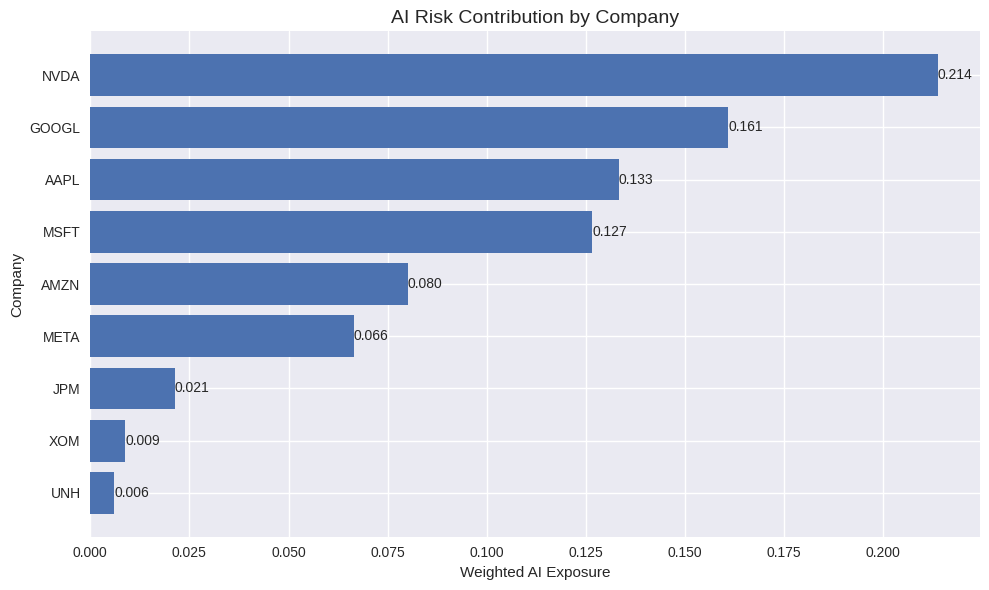

In [26]:
import matplotlib.pyplot as plt

df_plot = df.sort_values("AI_Weighted_Exposure", ascending=True)

plt.figure(figsize=(10, 6))
bars = plt.barh(
    df_plot["Ticker"],
    df_plot["AI_Weighted_Exposure"]
)

plt.title("AI Risk Contribution by Company", fontsize=14)
plt.xlabel("Weighted AI Exposure")
plt.ylabel("Company")

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.3f}",
        va="center",
        ha="left"
    )

plt.tight_layout()
plt.show()

** Stress Test: What is AI breaks tomorrow **

Companies with higher AI exposure fall more

Loss is not uniform
# Shock Impact(i) ​= AI Exposure(i) * Shock Severity

In [27]:
ai_shock = -0.20 #lets say AI shock impact is -20% for a business dependent on AI

In [28]:
df["AI_Shock_Return"] = df["AI_Exposure"] * ai_shock #what will be the company level impact based on their AI dependency
df["AI_Exposure"]

,AI_Exposure
0,0.70
1,0.90
2,0.95
3,0.75
4,0.90
5,0.85
6,0.55
7,0.50
8,0.30


In [29]:
df["Weighted_Shock_Impact"] = df["Weight"] * df["AI_Shock_Return"] #portfolio impact

portfolio_shock_loss = df["Weighted_Shock_Impact"].sum()

portfolio_shock_loss

np.float64(-0.16344635494881407)

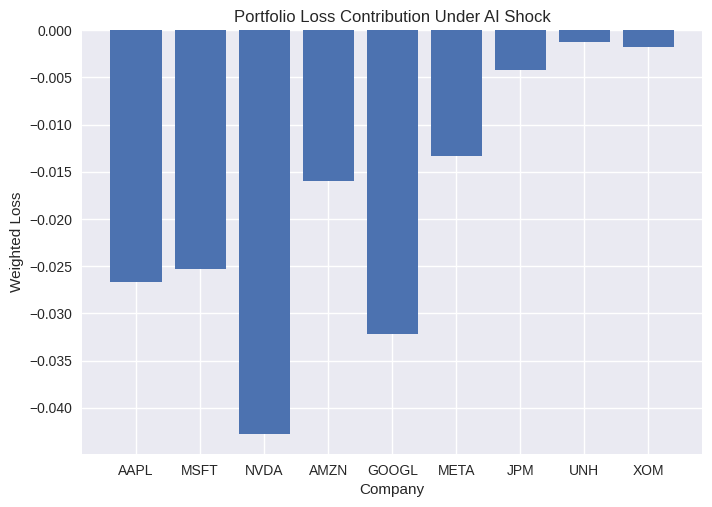

In [31]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(df["Ticker"], df["Weighted_Shock_Impact"])
plt.title("Portfolio Loss Contribution Under AI Shock")
plt.xlabel("Company")
plt.ylabel("Weighted Loss")
plt.show()

correlation

In [32]:
normal_corr = 0.30

In [33]:
ai_crisis_corr = 0.85

In [34]:
normal_risk = normal_corr * portfolio_ai_exposure
crisis_risk = ai_crisis_corr * portfolio_ai_exposure

risk_multiplier = crisis_risk / normal_risk #Portfolio variance intuition

risk_multiplier

np.float64(2.833333333333333)

Under an AI-driven systemic event, portfolio risk increases nearly 3× due to correlation convergence, even though the portfolio is diversified by sector.

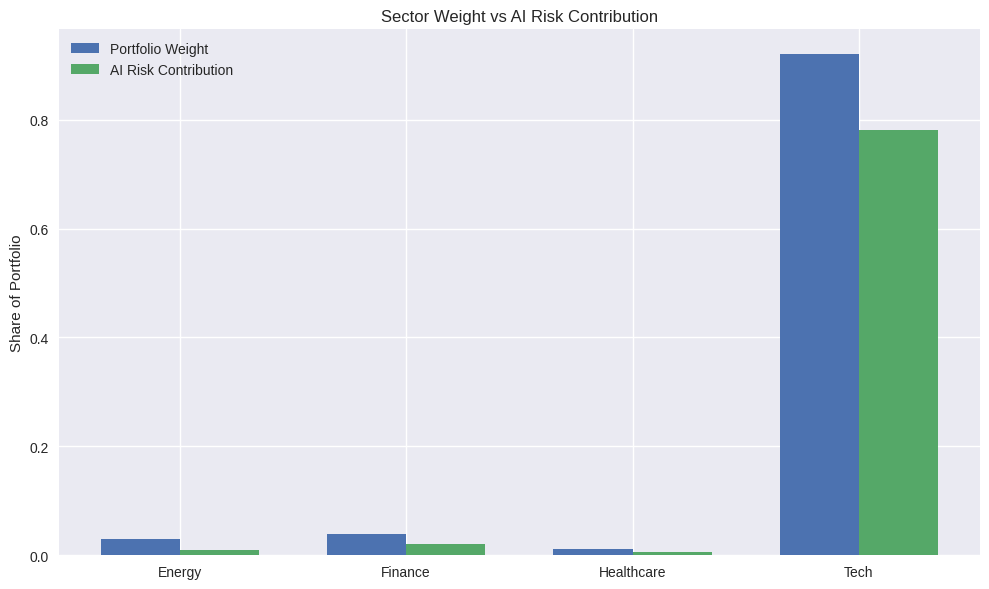

In [36]:
import numpy as np

# Define sector_ai by grouping df by Sector and summing the relevant columns
sector_ai = df.groupby("Sector").agg(
    Weight=("Weight", "sum"),
    AI_Weighted_Exposure=("AI_Weighted_Exposure", "sum")
).reset_index()

x = np.arange(len(sector_ai))
width = 0.35

plt.figure(figsize=(10, 6))

plt.bar(x - width/2, sector_ai["Weight"], width, label="Portfolio Weight")
plt.bar(x + width/2, sector_ai["AI_Weighted_Exposure"], width, label="AI Risk Contribution")

plt.xticks(x, sector_ai["Sector"])
plt.ylabel("Share of Portfolio")
plt.title("Sector Weight vs AI Risk Contribution")
plt.legend()

plt.tight_layout()
plt.show()

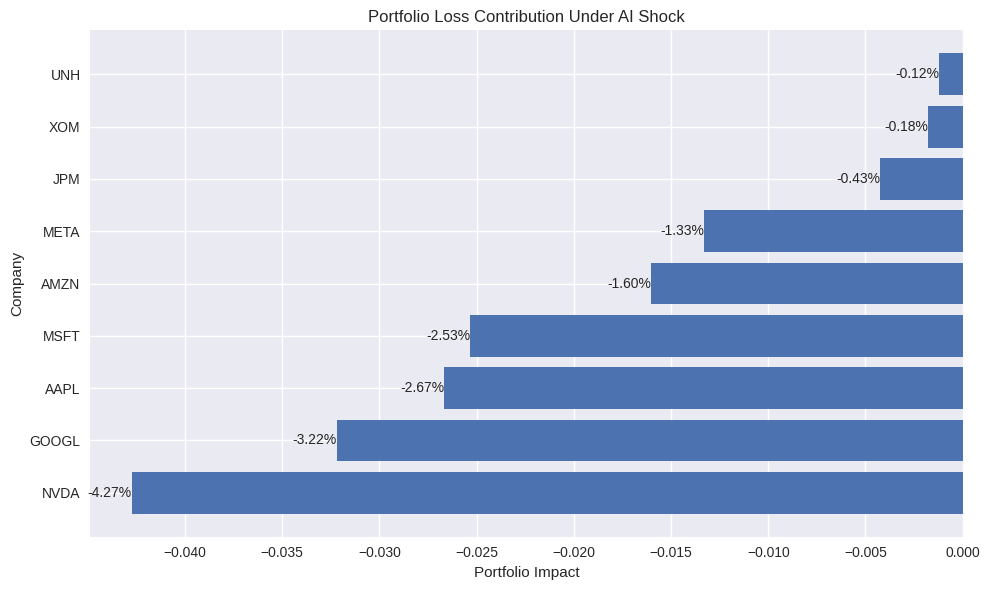

In [38]:
df_shock = df.sort_values("Weighted_Shock_Impact")

plt.figure(figsize=(10, 6))
bars = plt.barh(
    df_shock["Ticker"],
    df_shock["Weighted_Shock_Impact"]
)

plt.title("Portfolio Loss Contribution Under AI Shock")
plt.xlabel("Portfolio Impact")
plt.ylabel("Company")

for bar in bars:
    width = bar.get_width()
    plt.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.2%}",
        va="center",
        ha="right"
    )

plt.tight_layout()
plt.show()

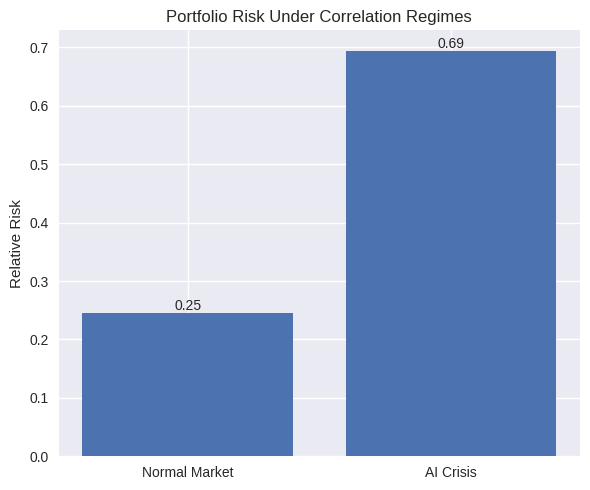

In [39]:
plt.figure(figsize=(6, 5))

plt.bar(
    ["Normal Market", "AI Crisis"],
    [normal_risk, crisis_risk]
)

plt.title("Portfolio Risk Under Correlation Regimes")
plt.ylabel("Relative Risk")

for i, v in enumerate([normal_risk, crisis_risk]):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

Modern portfolios and companies are not diversified the way we think.
Even non-tech firms are deeply exposed to technology and AI infrastructure.
When a tech/AI shock happens, risks collide across sectors, amplifying losses.

In [ ]:
import seaborn as sns

plt.style.use("seaborn-v0_8")

In [43]:
import yfinance as yf
import numpy as np

# Download historical data for the tickers
ticker_list = list(tickers.keys())
data = yf.download(ticker_list, period="1y")

# Calculate daily returns for 'Close' prices
returns = data['Close'].pct_change().dropna()

# Create AI exposure vector (using the previously defined ai_exposure_map)
ai_vector = np.array([ai_exposure_map[t] for t in returns.columns])

# Normalize
ai_vector = ai_vector / ai_vector.sum()

# Construct AI factor time series
ai_factor = returns.dot(ai_vector)

ai_factor.name = "AI_Factor"
print(ai_factor.head())

/tmp/ipython-input-2032/3509481318.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker_list, period="1y")
[*********************100%***********************]  9 of 9 completed

Date
2025-02-27   -0.024849
2025-02-28    0.018493
2025-03-03   -0.031073
2025-03-04   -0.001117
2025-03-05    0.013597
Name: AI_Factor, dtype: float64


In [44]:
corr_df = returns.copy()
corr_df["AI_Factor"] = ai_factor

corr_matrix = corr_df.corr()

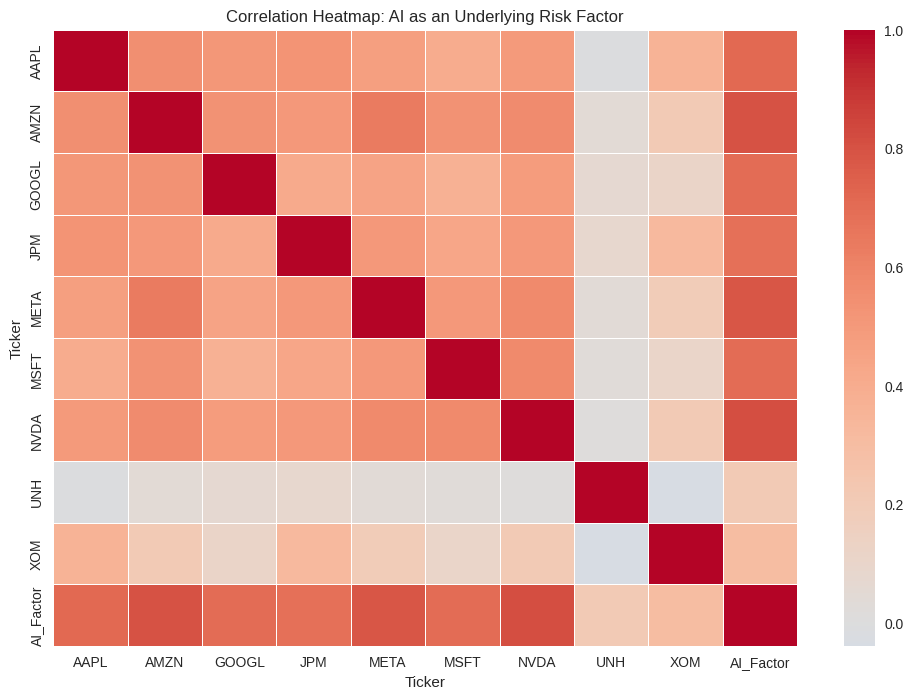

In [45]:
plt.figure(figsize=(12,8))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)

plt.title("Correlation Heatmap: AI as an Underlying Risk Factor")
plt.show()

Highly and moderately correlated

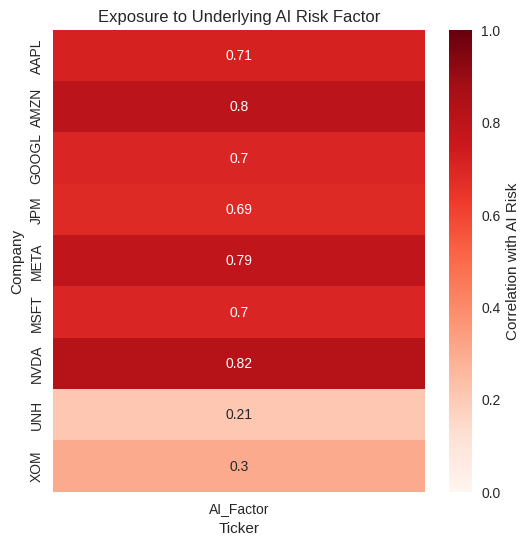

In [56]:
ai_corr = corr_matrix[["AI_Factor"]].drop("AI_Factor")

plt.figure(figsize=(6,6))
sns.heatmap(
    ai_corr,
    annot=True,
    cmap="Reds",
    vmin=0,
    vmax=1,
    cbar_kws={"label": "Correlation with AI Risk"}
)

plt.title("Exposure to Underlying AI Risk Factor")
plt.ylabel("Company")
plt.show()

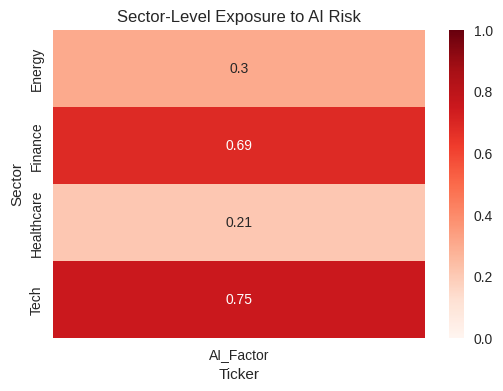

In [57]:
sector_map = {
    "AAPL":"Tech","MSFT":"Tech","NVDA":"Tech","AMZN":"Tech","GOOGL":"Tech","META":"Tech",
    "JPM":"Finance","UNH":"Healthcare","XOM":"Energy"
}

ai_corr["Sector"] = ai_corr.index.map(sector_map)
sector_ai_corr = ai_corr.groupby("Sector").mean()

plt.figure(figsize=(6,4))
sns.heatmap(
    sector_ai_corr,
    annot=True,
    cmap="Reds",
    vmin=0,
    vmax=1
)

plt.title("Sector-Level Exposure to AI Risk")
plt.show()

Pre Ai Vs Post Ai

In [60]:
prices = yf.download(
    list(tickers.keys()), # Pass a list of ticker symbols, not the dictionary
    start="2015-01-01",
    progress=False
)["Close"]

returns = prices.pct_change().dropna()

/tmp/ipython-input-2032/1680121165.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(


In [61]:
pre_ai = returns.loc["2015-01-01":"2019-12-31"]
post_ai = returns.loc["2020-01-01":]

In [62]:
def avg_pairwise_corr(df):
    corr = df.corr()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    return upper.stack().mean()

pre_avg_corr = avg_pairwise_corr(pre_ai)
post_avg_corr = avg_pairwise_corr(post_ai)

pre_avg_corr, post_avg_corr

(np.float64(0.42385092671085556), np.float64(0.4200347114944958))

In [64]:
ai_vector = np.array([ai_exposure_map[t] for t in returns.columns])
ai_vector = ai_vector / ai_vector.sum()

def build_ai_factor(df):
    return df.dot(ai_vector)

pre_ai_factor = build_ai_factor(pre_ai)
post_ai_factor = build_ai_factor(post_ai)

In [65]:
pre_corr_ai = pre_ai.corrwith(pre_ai_factor)
post_corr_ai = post_ai.corrwith(post_ai_factor)

In [66]:
corr_compare = pd.DataFrame({
    "Pre-AI": pre_corr_ai,
    "Post-AI": post_corr_ai,
    "Change": post_corr_ai - pre_corr_ai
}).sort_values("Change", ascending=False)

corr_compare

,Pre-AI,Post-AI,Change
Ticker,,,
NVDA,0.735077,0.820105,0.085028
AAPL,0.720331,0.789845,0.069514
META,0.729855,0.777018,0.047163
MSFT,0.812010,0.856506,0.044496
GOOGL,0.796702,0.816081,0.019379
AMZN,0.765982,0.778216,0.012234
JPM,0.597764,0.558879,-0.038885
UNH,0.509289,0.399495,-0.109794
XOM,0.480490,0.350233,-0.130257


In [70]:
ai_shock_days = post_ai_factor < post_ai_factor.quantile(0.05)
def max_drawdown(series):
    cum = (1 + series).cumprod()
    peak = cum.cummax()
    return ((cum - peak) / peak).min()

drawdowns = {}

for ticker in post_ai.columns:
    normal_dd = max_drawdown(post_ai[ticker])
    stress_dd = max_drawdown(post_ai.loc[ai_shock_days, ticker])
    drawdowns[ticker] = {
        "Normal": normal_dd,
        "AI Stress": stress_dd
    }

dd_df = pd.DataFrame(drawdowns).T
dd_df
def max_drawdown(series):
    cum = (1 + series).cumprod()
    peak = cum.cummax()
    return ((cum - peak) / peak).min()

drawdowns = {}

for ticker in post_ai.columns:
    normal_dd = max_drawdown(post_ai[ticker])
    stress_dd = max_drawdown(post_ai.loc[ai_shock_days, ticker])
    drawdowns[ticker] = {
        "Normal": normal_dd,
        "AI Stress": stress_dd
    }

dd_df = pd.DataFrame(drawdowns).T
dd_df

,Normal,AI Stress
AAPL,-0.333605,-0.950752
AMZN,-0.561453,-0.960835
GOOGL,-0.443200,-0.953953
JPM,-0.436265,-0.889810
META,-0.767361,-0.983139
MSFT,-0.371485,-0.939590
NVDA,-0.663351,-0.989397
UNH,-0.613909,-0.807800
XOM,-0.550049,-0.823881


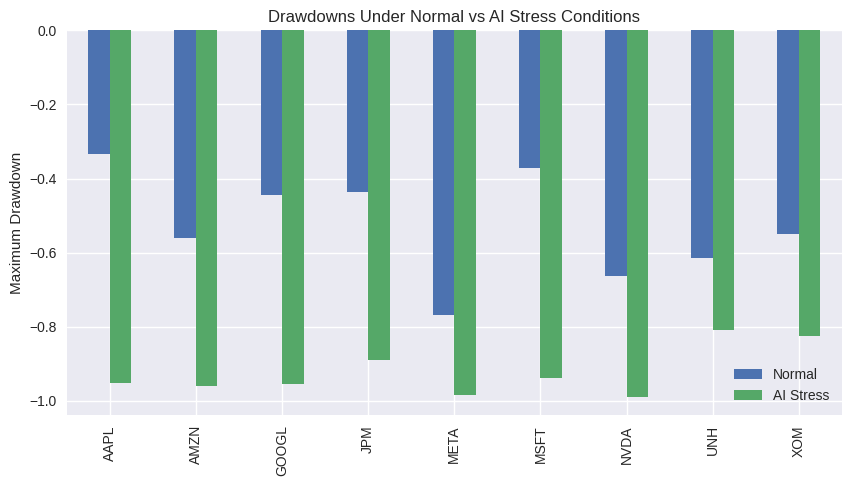

In [71]:
dd_df.plot(
    kind="bar",
    figsize=(10,5),
    title="Drawdowns Under Normal vs AI Stress Conditions"
)

plt.ylabel("Maximum Drawdown")
plt.show()